# 1. All image csv

In [87]:
import os
import csv

def create_csv(image_folder, csv_file_path):
    # CSV header
    fieldnames = ['HospitalID', 'PatientID', 'ImageID', 'ImagePath', 'Label']
    
    # open the CSV file in write mode
    with open(csv_file_path, 'w', newline='') as csvfile:
        # Create a CSV writer object and write the header
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for filename in sorted(os.listdir(image_folder)):
            # complete image file path
            image_path = os.path.join(image_folder, filename)

            # filename to extract HospitalID, PatientID, image number, and image label
            parts = filename.split('_')
            hospital_id = parts[3]
            patient_id = parts[1]
            image_number = parts[6]
            image_label = parts[4]

            # write data into the CSV file
            writer.writerow({
                'HospitalID': hospital_id,
                'PatientID': patient_id,
                'ImageID': image_number,
                'ImagePath': image_path,
                'Label': image_label
            })

    # created and saved
    print("CSV file has been created and saved to:", csv_file_path)


image_folder = "/local/data1/honzh073/data/8bit_down224"
csv_file_path = "/local/data1/honzh073/local_repository/FL/code/3_single_hospital/all_image.csv"
create_csv(image_folder, csv_file_path)


CSV file has been created and saved to: /local/data1/honzh073/local_repository/FL/code/3_single_hospital/all_image.csv


# 2. Single hospital image csv

In [88]:
import csv
import os
from collections import defaultdict

def filter_hospital_data(input_csv_path, target_hospital_ids):
    patient_data = defaultdict(list)

    with open(input_csv_path, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row['HospitalID'] in target_hospital_ids:
                patient_id = row['PatientID']
                patient_data[patient_id].append(row)

    hospital_55_data = []
    for images in patient_data.values():
        hospital_55_data.extend(images)

    return hospital_55_data

# Input and output paths
input_csv_path = '/local/data1/honzh073/local_repository/FL/code/3_single_hospital/all_image.csv'
output_folder = '/local/data1/honzh073/local_repository/FL/code/3_single_hospital'
# Single hospital id
target_hospital_ids = ['55']

# Get data for hospital 55
hospital_55_data = filter_hospital_data(input_csv_path, target_hospital_ids)

# Write hospital 55 data to CSV file
def write_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=data[0].keys())
        writer.writeheader()
        writer.writerows(data)

# Save hospital 55 data to 'hospital55.csv'
write_to_csv(os.path.join(output_folder, 'hospital55.csv'), hospital_55_data)

print("Saved single hospital csv.")


Saved single hospital csv.


# 3. create Random pick data

In [89]:
import random
import pandas as pd
# seed
random_seed = 1
random.seed(random_seed)

# origin csv
file_path = '/local/data1/honzh073/local_repository/FL/code/3_single_hospital/all_image.csv'
df = pd.read_csv(file_path)

# hospital ID
excluded_hospitals = [18, 43, 55, 100]

# random pick 3 patients from the rest hospitals
selected_data = []
for hospital_id in df['HospitalID'].unique():
    if hospital_id not in excluded_hospitals:
        patients = df[df['HospitalID'] == hospital_id]['PatientID'].unique()
        selected_patients = random.sample(list(patients), min(3, len(patients)))
        for patient_id in selected_patients:
            patient_data = df[(df['HospitalID'] == hospital_id) & (df['PatientID'] == patient_id)]
            selected_data.append(patient_data)

# concat to new DataFrame
selected_df = pd.concat(selected_data)

# create as new csv file
output_file_path = '/local/data1/honzh073/local_repository/FL/code/3_single_hospital/randompick_patient_data.csv'
selected_df.to_csv(output_file_path, index=False)

total_patients = selected_df['PatientID'].nunique()

total_images = selected_df.shape[0]

aff_patients = selected_df[selected_df['Label'] == 'AFF']['PatientID'].nunique()

nff_patients = selected_df[selected_df['Label'] == 'NFF']['PatientID'].nunique()

nff_images = selected_df[selected_df['Label'] == 'NFF'].shape[0]

aff_images = selected_df[selected_df['Label'] == 'AFF'].shape[0]

aff_patient_ratio = aff_patients / total_patients
nff_patient_ratio = nff_patients / total_patients
nff_image_ratio = nff_images / total_images
aff_image_ratio = aff_images / total_images

print(f"Total Patients: {total_patients}")
print(f"Total Images: {total_images}")
print(f"AFF Patients: {aff_patients}")
print(f"NFF Patients: {nff_patients}")
print(f"AFF Images: {aff_images}")
print(f"NFF Images: {nff_images}")
print(f"AFF Patient Ratio: {aff_patient_ratio:.2f}")
print(f"NFF Patient Ratio: {nff_patient_ratio:.2f}")
print(f"AFF Image Ratio: {aff_image_ratio:.2f}")
print(f"NFF Image Ratio: {nff_image_ratio:.2f}")


Total Patients: 168
Total Images: 587
AFF Patients: 30
NFF Patients: 138
AFF Images: 95
NFF Images: 492
AFF Patient Ratio: 0.18
NFF Patient Ratio: 0.82
AFF Image Ratio: 0.16
NFF Image Ratio: 0.84


# Functions

In [90]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
   
def show_image(dataset, num_images=5):
    # Get random indices
    random_indices = np.random.choice(len(dataset), num_images, replace=False)

    # Plot images with truncated names
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]  # Use the dataset directly
        filename = dataset.data[idx][0]  # Get the filename from dataset's internal data attribute
        truncated_filename = filename.split('/')[-1][:15]  # Extract the last part and truncate to 15 characters
        
        # Print the original filename
        print(f"Image location: {filename}")

        plt.subplot(1, num_images, i + 1)
        plt.title(f"Label: {label}")
        plt.imshow(image[0])  # Assuming single-channel (grayscale) image
        # plt.imshow(image[0], cmap='gray')  # Assuming single-channel (grayscale) image

        plt.axis('off')
    plt.show()
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_classweight(train_dataset):
    train_nff_count = sum(1 for _, label in train_dataset if label == 0)  # 0 NFF
    train_aff_count = sum(1 for _, label in train_dataset if label == 1)  # 1 AFF
    class_weight_nff = 1 / (2 * (train_nff_count / (train_nff_count + train_aff_count)))
    class_weight_aff = 1 / (2 * (train_aff_count / (train_nff_count + train_aff_count)))
    
    return [class_weight_nff, class_weight_aff] # 0 nff , 1 aff

def plot_roc_curve(all_labels, all_predictions):
    fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
    roc_auc = roc_auc_score(all_labels, all_predictions)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

def test_model(model, test_dataset, batch_size):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    model.eval()
    
    correct_test = 0
    total_test = 0
    test_loss = 0
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        all_predictions = []
        all_labels = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            test_loss += loss.item()

    test_accuracy = 100 * correct_test / total_test
    test_loss /= len(test_loader)
    
    auc_score = roc_auc_score(all_labels, all_predictions)
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    class_labels = {0: 'NFF', 1: 'AFF'}
    classification_rep = classification_report(all_labels, all_predictions, target_names=[class_labels[i] for i in range(len(class_labels))])
    
    # Store metrics in a dictionary
    metrics = {
        "Test Loss": test_loss,
        "Test Accuracy": test_accuracy,
        "AUC": auc_score,
        "Confusion Matrix": conf_matrix,
        "Classification Report": classification_rep
    }
    plot_roc_curve(all_labels, all_predictions)

    return metrics




training class weight [0.7590361445783133, 1.4651162790697674]
Image location: /local/data1/honzh073/data/8bit_down224/patient_VCYAFOQEQN_hospital_18_AFF_image_4.png
Image location: /local/data1/honzh073/data/8bit_down224/patient_XWVGPALIEE_hospital_18_NFF_image_5.png
Image location: /local/data1/honzh073/data/8bit_down224/patient_ITMNMLEHWW_hospital_18_NFF_image_2.png
Image location: /local/data1/honzh073/data/8bit_down224/patient_NJBJGFVKBJ_hospital_18_NFF_image_5.png
Image location: /local/data1/honzh073/data/8bit_down224/patient_HOPFPVLORH_hospital_18_AFF_image_4.png
Image location: /local/data1/honzh073/data/8bit_down224/patient_NMWJLZBZER_hospital_18_NFF_image_2.png
Image location: /local/data1/honzh073/data/8bit_down224/patient_JDYQZFVMPB_hospital_18_NFF_image_2.png
Image location: /local/data1/honzh073/data/8bit_down224/patient_ITMNMLEHWW_hospital_18_NFF_image_1.png
Image location: /local/data1/honzh073/data/8bit_down224/patient_NSEIEIKOBO_hospital_18_NFF_image_4.png
Image loca

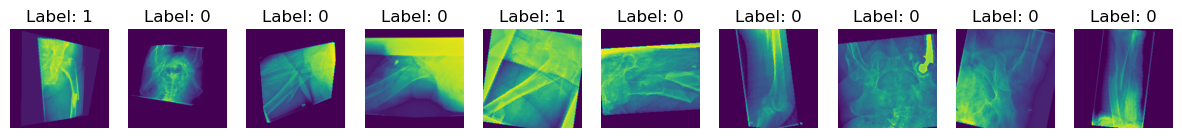

Saved train.csv, val.csv, test.csv.
-----------------------------------
train AFF: 43, ratio: 0.34
----- NFF: 83, ratio: 0.66
-----------------------------------
test AFF: 95, ratio: 0.16
---- NFF: 492, ratio: 0.84


In [91]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import csv
from torchvision import transforms, models
from sklearn.model_selection import KFold

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = []
        self.labels = []  # Store labels separately
        self.patient_ids = []  # Store patient IDs separately
        self.transform = transform
        
        # read csv
        with open(csv_file, 'r') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                image_path = row['ImagePath']
                label = row['Label']
                patient_id = row['PatientID']  # Assuming 'PatientID' is the column name in your CSV file

                if label == 'NFF':
                    label = 0
                elif label == 'AFF':
                    label = 1
                else:
                    raise ValueError("Invalid label in CSV file.")
                self.data.append((image_path, label))
                self.labels.append(label)
                self.patient_ids.append(patient_id)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Define your image transformations for training and testing
from torchvision import transforms

# 定义图像转换操作
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),
    transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.5, p=1)], p=0.1),
    # transforms.RandomApply([transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2))], p=0.1),  # 随机仿射变换
    # transforms.RandomApply([transforms.RandomResizedCrop(224, scale=(0.5, 1.0), ratio=(0.75, 1.3333))], p=0.1),  # 随机大小和宽高比裁剪
    transforms.RandomApply([transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2)], p=0.1),  # 调整颜色饱和度和亮度
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 随机平移
    # transforms.RandomPerspective(distortion_scale=0.5),  # 随机透视
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Load the datasets using CustomDataset class
train_dataset = CustomDataset('/local/data1/honzh073/local_repository/FL/code/3_single_hospital/hospital55.csv', transform=train_transform)
test_dataset = CustomDataset('/local/data1/honzh073/local_repository/FL/code/3_single_hospital/randompick_patient_data.csv', transform=test_transform)

# classweight
classweight = get_classweight(train_dataset)
print('training class weight', classweight)

# device
# device = torch.device("cuda:0" if  torch.cuda.is_available() else "cpu")

# print images
show_image(train_dataset, 10)

# calculate numbers
print("Saved train.csv, val.csv, test.csv.")
print('-----------------------------------')
train_NFF_count = sum(1 for _, label in train_dataset if label == 0)  # 0 NFF
train_AFF_count = sum(1 for _, label in train_dataset if label == 1)  # 1 AFF
test_NFF_count = sum(1 for _, label in test_dataset if label == 0)  # 0 NFF
test_AFF_count = sum(1 for _, label in test_dataset if label == 1)  # 1 AFF

print(f"train AFF: {train_AFF_count}, ratio: {train_AFF_count / (train_AFF_count + train_NFF_count):.2f}")
print(f"----- NFF: {train_NFF_count}, ratio: {train_NFF_count / (train_AFF_count + train_NFF_count):.2f}")
print('-----------------------------------')
print(f"test AFF: {test_AFF_count}, ratio: {test_AFF_count / (test_AFF_count + test_NFF_count):.2f}")
print(f"---- NFF: {test_NFF_count}, ratio: {test_NFF_count / (test_AFF_count + test_NFF_count):.2f}")



# Resnet 101

In [92]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold

def train_custom_model(model, train_dataset, num_epochs=20, batch_size=16, learning_rate=0.0001, optimizer=None):
    classweight = get_classweight(train_dataset) # get_classweight is a function defined above
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss(weight=torch.Tensor(classweight).to(device))
    
    n_splits = 5
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

    for fold, (train_idx, val_idx) in enumerate(kf.split(range(len(train_dataset)), train_dataset.patient_ids)):
        print(f'Fold {fold + 1}/{n_splits}')

        train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)

        for epoch in range(num_epochs):
            model.train()
            correct_train = 0
            total_train = 0

            for images, labels in train_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            train_accuracy = 100 * correct_train / total_train

            model.eval()
            correct_validation = 0
            total_validation = 0
            validation_loss = 0

            with torch.no_grad():
                for images, labels in val_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    _, predicted = torch.max(outputs.data, 1)
                    total_validation += labels.size(0)
                    correct_validation += (predicted == labels).sum().item()
                    validation_loss += loss.item()

            validation_accuracy = 100 * correct_validation / total_validation
            validation_loss /= len(val_loader)

            print(f"Epoch {epoch+1}/{num_epochs}, "
                f"train ACC: {train_accuracy:.2f}%, "
                f"Val ACC: {validation_accuracy:.2f}%")


# VGG 19

/local/data1/honzh073/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fold 1/5
Epoch 1/20, train ACC: 48.00%, Val ACC: 61.54%
Epoch 2/20, train ACC: 62.00%, Val ACC: 76.92%
Epoch 3/20, train ACC: 64.00%, Val ACC: 61.54%
Epoch 4/20, train ACC: 67.00%, Val ACC: 65.38%
Epoch 5/20, train ACC: 67.00%, Val ACC: 57.69%
Epoch 6/20, train ACC: 68.00%, Val ACC: 61.54%
Epoch 7/20, train ACC: 73.00%, Val ACC: 53.85%
Epoch 8/20, train ACC: 58.00%, Val ACC: 65.38%
Epoch 9/20, train ACC: 77.00%, Val ACC: 61.54%
Epoch 10/20, train ACC: 76.00%, Val ACC: 61.54%
Epoch 11/20, train ACC: 70.00%, Val ACC: 57.69%
Epoch 12/20, train ACC: 65.00%, Val ACC: 61.54%
Epoch 13/20, train ACC: 72.00%, Val ACC: 73.08%
Epoch 14/20, train ACC: 80.00%, Val ACC: 80.77%
Epoch 15/20, train ACC: 85.00%, Val ACC: 61.54%
Epoch 16/20, train ACC: 69.00%, Val ACC: 73.08%
Epoch 17/20, train ACC: 80.00%, Val ACC: 76.92%
Epoch 18/20, train ACC: 77.00%, Val ACC: 73.08%
Epoch 19/20, train ACC: 91.00%, Val ACC: 69.23%
Epoch 20/20, train ACC: 72.00%, Val ACC: 80.77%
Fold 2/5
Epoch 1/20, train ACC: 83.17%, 

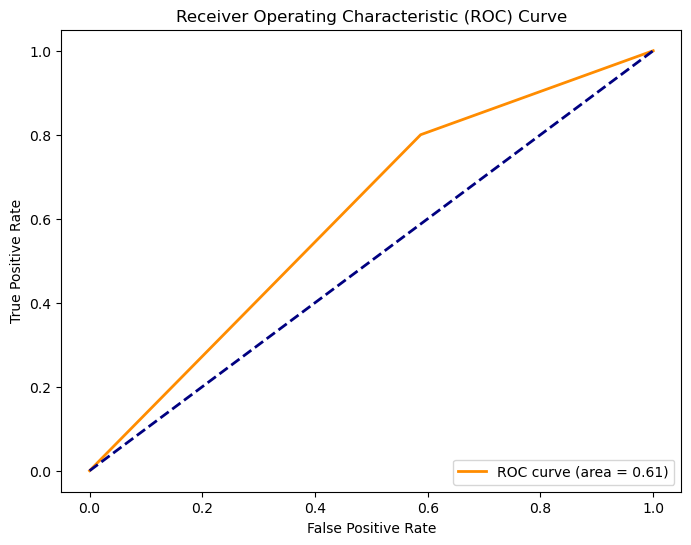

{'Test Loss': 1.0091527088268384, 'Test Accuracy': 47.52981260647359, 'AUC': 0.6063008130081301, 'Confusion Matrix': array([[203, 289],
       [ 19,  76]]), 'Classification Report': '              precision    recall  f1-score   support\n\n         NFF       0.91      0.41      0.57       492\n         AFF       0.21      0.80      0.33        95\n\n    accuracy                           0.48       587\n   macro avg       0.56      0.61      0.45       587\nweighted avg       0.80      0.48      0.53       587\n'}


In [93]:
from torchvision.models import vgg19, VGG19_Weights


torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# Define the VGG-19 model
model = models.vgg19(weights=VGG19_Weights.DEFAULT)

# Modify the classifier part of the model
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 2)

# layer number
total_layers = len(list(model.features.children()))

# freeze 50% layer
freeze_layers = int(total_layers * 0.5)
for index, child in enumerate(model.features.children()):
    if index < freeze_layers:
        for param in child.parameters():
            param.requires_grad = False
# ---------------------------------------------------------------------------------------------------------
# Hyper parameters
num_epochs = 20
batch_size = 16
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# ---------------------------------------------------------------------------------------------------------

train_custom_model(model, train_dataset, num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate, optimizer=optimizer)
print('####################################################################################')

vgg19_metrics = test_model(model, test_dataset, batch_size=16)
print(vgg19_metrics)

# ResNet50

In [94]:
from torchvision.models import resnet50, ResNet50_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# Define the ResNet-50 model
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

# layer number
total_layers = len(list(model.children()))

# freeze 50% layer
freeze_layers = int(total_layers * 0.5)
for index, child in enumerate(model.children()):
    if index < freeze_layers:
        for param in child.parameters():
            param.requires_grad = False

# modify full connection layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# ---------------------------------------------------------------------------------------------------------
# Hyper parameters
num_epochs = 20
batch_size = 16
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# ---------------------------------------------------------------------------------------------------------

train_custom_model(model, train_dataset, num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate, optimizer=optimizer)

print('####################################################################################')

resnet50_metrics = test_model(model, test_dataset, batch_size=16)
print(resnet50_metrics)

/local/data1/honzh073/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fold 1/5
Epoch 1/20, train ACC: 49.00%, Val ACC: 53.85%
Epoch 2/20, train ACC: 69.00%, Val ACC: 61.54%
Epoch 3/20, train ACC: 68.00%, Val ACC: 65.38%
Epoch 4/20, train ACC: 75.00%, Val ACC: 73.08%
Epoch 5/20, train ACC: 77.00%, Val ACC: 53.85%
Epoch 6/20, train ACC: 72.00%, Val ACC: 65.38%
Epoch 7/20, train ACC: 83.00%, Val ACC: 80.77%
Epoch 8/20, train ACC: 83.00%, Val ACC: 69.23%
Epoch 9/20, train ACC: 86.00%, Val ACC: 80.77%
Epoch 10/20, train ACC: 84.00%, Val ACC: 80.77%
Epoch 11/20, train ACC: 87.00%, Val ACC: 80.77%
Epoch 12/20, train ACC: 86.00%, Val ACC: 73.08%
Epoch 13/20, train ACC: 92.00%, Val ACC: 76.92%
Epoch 14/20, train ACC: 91.00%, Val ACC: 88.46%
Epoch 15/20, train ACC: 92.00%, Val ACC: 84.62%
Epoch 16/20, train ACC: 92.00%, Val ACC: 88.46%
Epoch 17/20, train ACC: 95.00%, Val ACC: 73.08%
Epoch 18/20, train ACC: 98.00%, Val ACC: 76.92%
Epoch 19/20, train ACC: 92.00%, Val ACC: 84.62%
Epoch 20/20, train ACC: 91.00%, Val ACC: 69.23%
Fold 2/5
Epoch 1/20, train ACC: 86.14%, 

# ResNet101

In [ ]:
from torchvision.models import resnet101, ResNet101_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# Define the ResNet-101 model
model = models.resnet101(weights=ResNet101_Weights.DEFAULT)

# layer number
total_layers = len(list(model.children()))

# freeze 50% layer
freeze_layers = int(total_layers * 0.5)
for index, child in enumerate(model.children()):
    if index < freeze_layers:
        for param in child.parameters():
            param.requires_grad = False

# modify full connection layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# ---------------------------------------------------------------------------------------------------------
# Hyper parameters
num_epochs = 20
batch_size = 16
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# ---------------------------------------------------------------------------------------------------------

train_custom_model(model, train_dataset, num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate, optimizer=optimizer)

print('####################################################################################')
resnet101_metrics = test_model(model, test_dataset, batch_size=16)
print(resnet101_metrics)


# ResNet 152

In [ ]:
from torchvision.models import resnet152, ResNet152_Weights
torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the ResNet-101 model
model = models.resnet152(weights=ResNet152_Weights.DEFAULT)

# total layers 
total_layers = len(list(model.children()))

# freeze 50% layers
freeze_layers = int(total_layers * 0.5)
for index, child in enumerate(model.children()):
    if index < freeze_layers:
        for param in child.parameters():
            param.requires_grad = False

# modify full connection (fc) layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
model = model.to(device)
# ---------------------------------------------------------------------------------------------------------
# Hyper parameters
num_epochs = 20
batch_size = 16
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# ---------------------------------------------------------------------------------------------------------

train_custom_model(model, train_dataset, num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate, optimizer=optimizer)

print('####################################################################################')
resnet152_metrics = test_model(model, test_dataset, batch_size=16)
print(resnet152_metrics)

# DenseNet 161

In [ ]:
from torchvision.models import densenet161, DenseNet161_Weights
torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# Define the DenseNet-161 model
model = models.densenet161(weights=DenseNet161_Weights.DEFAULT)

# Modify the classifier part of the model
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 2)

# total layers 
total_layers = len(list(model.features.children()))

# freeze 50% layers
freeze_layers = int(total_layers * 0.5)
for index, child in enumerate(model.features.children()):
    if index < freeze_layers:
        for param in child.parameters():
            param.requires_grad = False
            
# ---------------------------------------------------------------------------------------------------------
# Hyper parameters
num_epochs = 20
batch_size = 16
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# ---------------------------------------------------------------------------------------------------------

train_custom_model(model, train_dataset, num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate, optimizer=optimizer)

print('####################################################################################')
densenet161_metrics = test_model(model, test_dataset, batch_size=16)
print(densenet161_metrics)

In [ ]:

print("VGG-19 Metrics:")
print("Test Loss:", vgg19_metrics["Test Loss"])
print("Test Accuracy:", vgg19_metrics["Test Accuracy"])
print("AUC:", vgg19_metrics["AUC"])
print("Confusion Matrix:")
print(vgg19_metrics["Confusion Matrix"])
print("Classification Report:")
print(vgg19_metrics["Classification Report"])
print("\n")

# Manually format and compare the metrics for all models
print("ResNet-50 Metrics:")
print("Test Loss:", resnet50_metrics["Test Loss"])
print("Test Accuracy:", resnet50_metrics["Test Accuracy"])
print("AUC:", resnet50_metrics["AUC"])
print("Confusion Matrix:")
print(resnet50_metrics["Confusion Matrix"])
print("Classification Report:")
print(resnet50_metrics["Classification Report"])
print("\n")

print("ResNet-101 Metrics:")
print("Test Loss:", resnet101_metrics["Test Loss"])
print("Test Accuracy:", resnet101_metrics["Test Accuracy"])
print("AUC:", resnet101_metrics["AUC"])
print("Confusion Matrix:")
print(resnet101_metrics["Confusion Matrix"])
print("Classification Report:")
print(resnet101_metrics["Classification Report"])
print("\n")

print("ResNet-152 Metrics:")
print("Test Loss:", resnet152_metrics["Test Loss"])
print("Test Accuracy:", resnet152_metrics["Test Accuracy"])
print("AUC:", resnet152_metrics["AUC"])
print("Confusion Matrix:")
print(resnet152_metrics["Confusion Matrix"])
print("Classification Report:")
print(resnet152_metrics["Classification Report"])
print("\n")

print("DenseNet-161 Metrics:")
print("Test Loss:", densenet161_metrics["Test Loss"])
print("Test Accuracy:", densenet161_metrics["Test Accuracy"])
print("AUC:", densenet161_metrics["AUC"])
print("Confusion Matrix:")
print(densenet161_metrics["Confusion Matrix"])
print("Classification Report:")
print(densenet161_metrics["Classification Report"])


In [ ]:
# VGG-19
print("VGG-19 Metrics:")
print("Test Loss:", round(vgg19_metrics["Test Loss"], 4))
print("Test Accuracy:", round(vgg19_metrics["Test Accuracy"], 2))
print("AUC:", round(vgg19_metrics["AUC"], 4))
print("\n")

# ResNet-50
print("ResNet-50 Metrics:")
print("Test Loss:", round(resnet50_metrics["Test Loss"], 4))
print("Test Accuracy:", round(resnet50_metrics["Test Accuracy"], 2))
print("AUC:", round(resnet50_metrics["AUC"], 4))
print("\n")

# ResNet-101
print("ResNet-101 Metrics:")
print("Test Loss:", round(resnet101_metrics["Test Loss"], 4))
print("Test Accuracy:", round(resnet101_metrics["Test Accuracy"], 2))
print("AUC:", round(resnet101_metrics["AUC"], 4))
print("\n")

# ResNet-152
print("ResNet-152 Metrics:")
print("Test Loss:", round(resnet152_metrics["Test Loss"], 4))
print("Test Accuracy:", round(resnet152_metrics["Test Accuracy"], 2))
print("AUC:", round(resnet152_metrics["AUC"], 4))
print("\n")

# DenseNet-161
print("DenseNet-161 Metrics:")
print("Test Loss:", round(densenet161_metrics["Test Loss"], 4))
print("Test Accuracy:", round(densenet161_metrics["Test Accuracy"], 2))
print("AUC:", round(densenet161_metrics["AUC"], 4))
print("\n")
